In [1]:
using Plots
using SolidStateDetectors
using Unitful

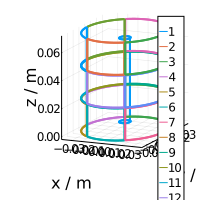

In [2]:
T = Float32
simulation = Simulation{T}(SSD_examples[:Coax])

plot(simulation.detector, size = (200, 200))

Electric Potential Calculation
Bias voltage: 6000.0 V
φ symmetry: calculating just 1/12 in φ of the detector.
Precision: Float32
Convergence limit: 1.0e-7 => 0.0006 V
Threads: 1
Coordinate system: cylindrical
Initial grid dimension: (64, 12, 160)
Refine? -> true
Refinement parameters:
	maximum number of refinements: 3
	minimum grid spacing:
		r: 1.0e-5 m
		φ: 0.001 rad
		z: 1.0e-5 m
	Refinement limits:
		r: 1.0e-5 -> 0.06 V
		φ: 0.001 -> 6.0 V
		z: 1.0e-5 -> 0.06 V



Convergence:  Time: 0:00:28 (165 iterations))
┌ Info: New Grid Size = (127, 13, 318)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:00:24 (55 iterations))
┌ Info: New Grid Size = (253, 14, 634)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:01:41 (59 iterations))m
┌ Info: New Grid Size = (505, 15, 1266)
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\Simulation\Simulation.jl:460
Convergence:  Time: 0:11:21 (48 iterations))m


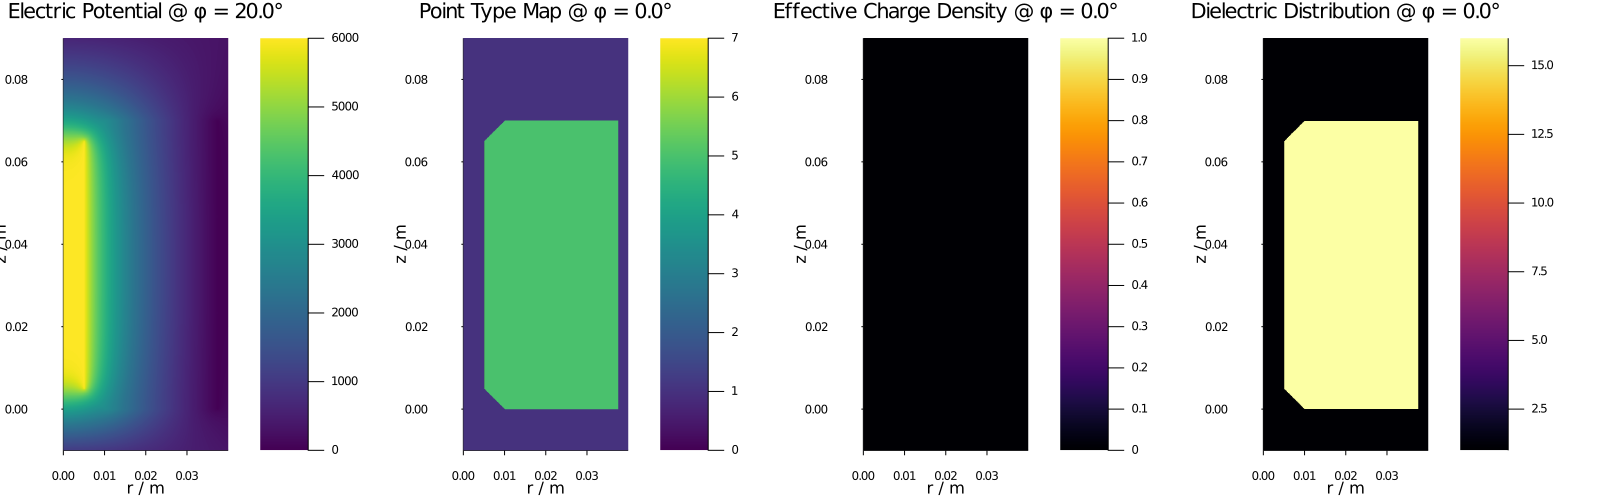

In [3]:
calculate_electric_potential!( simulation, max_refinements = 3)

plot(
    plot(simulation.electric_potential, φ = 20), # initial electric potential (boundary conditions)
    plot(simulation.point_types), # map of different point types: fixed point / inside or outside detector volume / depleted/undepleted
    plot(simulation.ρ), # charge density distribution
    plot(simulation.ϵ), # dielectric distribution
    layout = (1, 4), size = (1600, 500))

Convergence:  Time: 0:00:30 (52 iterations))
Checking undepleted regions 100%|███████████████████████| Time: 0:00:00
Convergence:  Time: 0:00:28 (18 iterations)
Checking undepleted regions 100%|███████████████████████| Time: 0:00:02
Convergence:  Time: 0:02:11 (17 iterations)
Checking undepleted regions 100%|███████████████████████| Time: 0:00:09
Convergence:  Time: 0:11:45 (17 iterations)


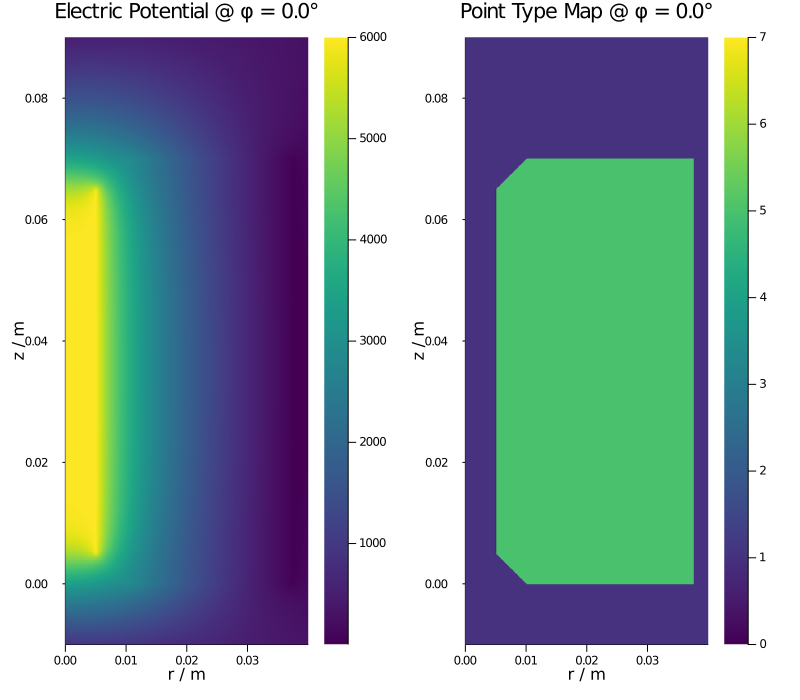

In [4]:
detector_undep = deepcopy(simulation.detector)
detector_undep.contacts[end].potential = 500; # V  <-- Bias Voltage of Mantle

simulation_undep = Simulation(detector_undep);
calculate_electric_potential!(simulation_undep, depletion_handling = true, convergence_limit=1e-6, max_refinements = 3, verbose = false)
plot(plot(simulation_undep.electric_potential), plot(simulation_undep.point_types), layout = (1, 2), size = (800, 700))

In [5]:
println("Depleted:   ", get_active_volume(simulation.point_types))
println("Undepleted: ", get_active_volume(simulation_undep.point_types));

LoadError: type PointTypes has no field φ

┌ Info: 36 drifts are now being simulated...
└ @ SolidStateDetectors C:\Users\Mohamed Emam\.julia\packages\SolidStateDetectors\48ipd\src\ElectricField\plot_recipes.jl:172
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


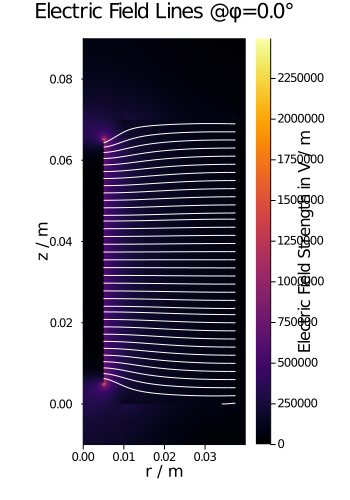

In [6]:
calculate_electric_field!(simulation, n_points_in_φ = 72)

plot(simulation.electric_field, φ = 0.0, size = (350, 500))
plot_electric_fieldlines!(simulation, φ = 0.0)

In [7]:
charge_drift_model = ADLChargeDriftModel()
set_charge_drift_model!(simulation, charge_drift_model)

In [8]:
calculate_drift_fields!(simulation)

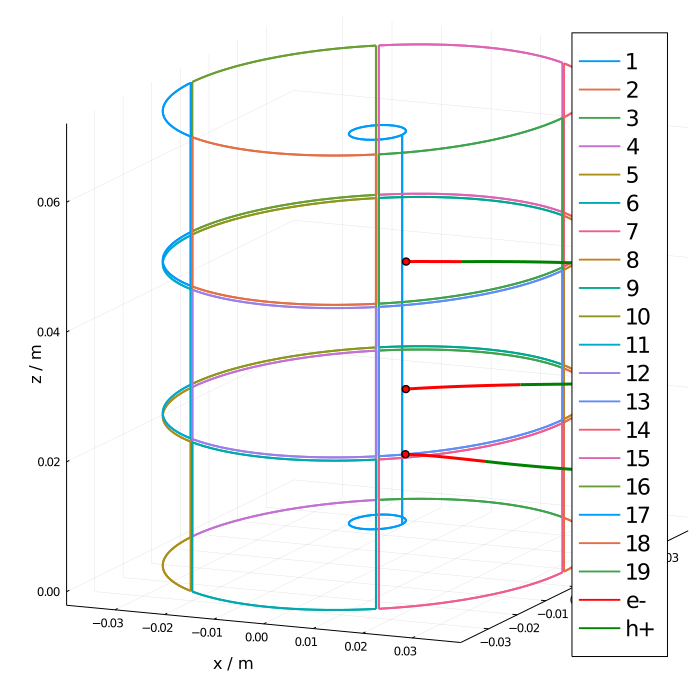

In [9]:
starting_positions = [ CylindricalPoint{T}( 0.020, deg2rad(10), 0.015 ),
                       CylindricalPoint{T}( 0.015, deg2rad(20), 0.045 ),
                       CylindricalPoint{T}( 0.025, deg2rad(30), 0.025 ) ]
energy_depos = T[1460, 609, 1000] * u"keV" # are needed later in the signal generation

event = Event(starting_positions, energy_depos);

time_step = 5u"ns"
drift_charges!(event, simulation, Δt = time_step)

plot(simulation.detector, size = (700, 700))
plot!(event.drift_paths)

In [ ]:
for contact in simulation.detector.contacts
    calculate_weighting_potential!(simulation, contact.id, max_refinements = 3, n_points_in_φ = 2, verbose = false)
end

plot(
    plot(simulation.weighting_potentials[1]),
    plot(simulation.weighting_potentials[2]),
    size = (900, 700)
)

Convergence:  Time: 0:00:18 (96 iterations)06)
Convergence:  Time: 0:01:28 (111 iterations)6)
Convergence:  Time: 0:03:09 (63 iterations)05)
Convergence:  Time: 0:24:55 (58 iterations)06)
Convergence:  Time: 0:00:14 (80 iterations)06)
Convergence:  Time: 0:01:40 (63 iterations)06)
Convergence:  (thresh = 1e-07, value = 6.38962e-05)

In [ ]:
simulate!(event, simulation) # drift_charges + signal generation of all channels

p_pc_signal = plot( event.waveforms[1], lw = 1.5, xlims = (0, 1100), xlabel = "Time / ns",
                    legend = false, tickfontsize = 12, ylabel = "Energy / eV", guidefontsize = 14)

In [ ]:
using RadiationSpectra
using Plots

h_uncal = RadiationSpectra.get_example_spectrum()
h_decon, peakpos = RadiationSpectra.peakfinder(h_uncal)
println(sort(peakpos)/1e3)
using Plots
p_uncal = plot(h_uncal, st=:step, label="Uncalibrated spectrum", c=1, lw=1.2);
p_decon = plot(peakpos, st=:vline, c=:red, label="Peaks", lw=0.3);
plot!(h_decon, st=:step, label="Deconvoluted spectrum", c=1, lw=1.2);
plot(p_uncal, p_decon, size=(800,500), layout=(2, 1), fmt=:svg)



In [ ]:
using Plots, RadiationSpectra

h_uncal = RadiationSpectra.get_example_spectrum()
h_cal, h_deconv, peakPositions, threshold, c, c_precal = RadiationSpectra.calibrate_spectrum(h_uncal, photon_lines)
p_uncal = plot(h_uncal, st=:step, label="Uncalibrated spectrum");
p_deconv = plot(h_deconv, st=:step, label = "Deconvoluted spectrum");
hline!([threshold], label = "threshold", lw = 1.5);
p_cal = plot(h_cal, st=:step, label="Calibrated spectrum", xlabel="E / keV");
vline!(photon_lines, lw=0.5, color=:red, label="Photon lines");
plot(p_uncal, p_deconv, p_cal, size=(800,700), layout=(3, 1), fmt=:svg)

In [ ]:
struct CustomChargeDriftModel{T <: SSDFloat} <: AbstractChargeDriftModel{T} 
    # optional fields to parameterize the model
end

In [ ]:
function SolidStateDetectors.getVe(fv::SVector{3, T}, cdm::CustomChargeDriftModel)::SVector{3, T} where {T <: SSDFloat}
    # arbitrary transformation of fv
    return -fv
end

function SolidStateDetectors.getVh(fv::SVector{3, T}, cdm::CustomChargeDriftModel)::SVector{3, T} where {T <: SSDFloat}
    # arbitrary transformation of fv
    return fv
end

In [ ]:
T = SolidStateDetectors.get_precision_type(simulation) # e.g. Float32
cdm = CustomChargeDriftModel{T}()
set_charge_drift_model!(simulation, cdm)
calculate_drift_fields!(simulation)